## *Import library:*

In [1]:
import os
import glob
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score


import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from tqdm.notebook import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
%matplotlib inline

C:\Users\windown\AppData\Local\Temp\ipykernel_18828\3715866102.py:22: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.measurements import label


## *Load Data:*

In [2]:
desired_shape = (720,1280)

processed_images = []

for img_path in glob.glob('D:/dataset/car detection/test_images/*jpg'):
    img = plt.imread(img_path)
    img_resized = resize(img,desired_shape)

    processed_images.append(img_resized)

test_images = np.array(processed_images)

Car_images = []
Non_car_images = []

for root, dirs, files in os.walk('D:/dataset/car detection/vehicles'):
    for file in files:
        if file.endswith('.png'):
            Car_images.append(os.path.join(root, file))

for root, dirs, files in os.walk('D:/dataset/car detection/non-vehicles'):
    for file in files:
        if file.endswith('.png'):
            Non_car_images.append(os.path.join(root, file))

In [3]:
n_car = len(Car_images)
n_non_car = len(Non_car_images)
img_shape = cv2.imread(Car_images[0]).shape

print('Number of car images: ', n_car)
print('Number of non-car images: ', n_non_car)
print('Images shape:',img_shape)

Number of car images:  8792
Number of non-car images:  8968
Images shape: (64, 64, 3)


## test thử các chức năng:

(array([  0,   0,   0,   0,   3,  16,  64, 131,  94, 104, 128, 108,  60,
        86, 102,  42,  27,  18,  15,  13,   8,   5,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0], dtype=int64), array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,
        88.,  96., 104., 112., 120., 128., 136., 144., 152., 160., 168.,
       176., 184., 192., 200., 208., 216., 224., 232., 240., 248., 256.]))


(array([16.,  3.,  2.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,
         2.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,
         88.,  96., 104., 112., 120., 128., 136., 144., 152., 160., 168.,
        176., 184., 192., 200., 208., 216., 224., 232., 240., 248., 256.]),
 <BarContainer object of 32 artists>)

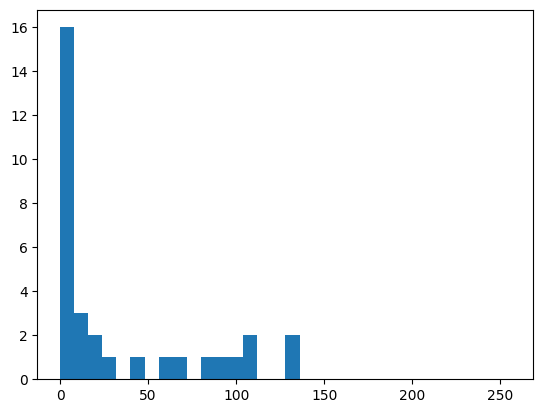

In [4]:
test = cv2.imread(Car_images[0])
#print(test)
#print(test.ravel())
#print(len(test.ravel()))
resize = (32,32)
test = cv2.resize(test,resize)
#print(test)
#print(test.ravel())
#print(len(test.ravel()))

channel1_hist = np.histogram(test[:,:,0], bins=32, range=(0,256))
print(channel1_hist)
plt.hist(channel1_hist[0], bins=32, range=(0,256))

## Tạo hàm visualize những sample từ data trên

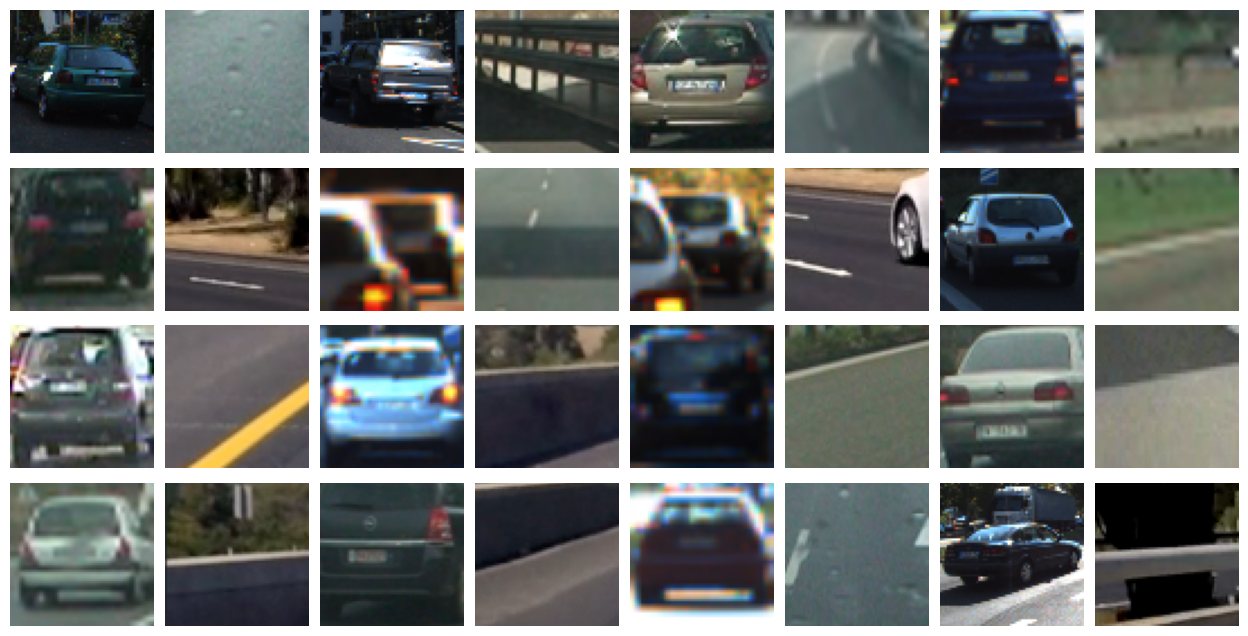

In [5]:
def visualize_samples(car_images, non_car_images, n_rows=4, n_cols=8, img_width=16, img_height=8):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(img_width,img_height))
    fig.subplots_adjust(hspace=0.1, wspace=0.001)

    images = []
    for _ in range(n_rows * n_cols // 2):
      images.append(random.choice(car_images))
      images.append(random.choice(non_car_images))

    for i in range(n_rows * n_cols):
        ax = axes[i // n_cols, i % n_cols]
        image = mpimg.imread(images[i])
        ax.imshow(image)
        ax.axis('off')

    plt.show()


visualize_samples(Car_images, Non_car_images)

## *Functions initializing*

In [6]:
def bin_spatial (img, size = (32,32)):
  img = cv2.resize(img, size).ravel()
  return img

def color_histogram (img, nbins=32, bins_range=(0,256)):
  channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
  channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
  channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
  hist = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
  return hist

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
  if vis == True:
    features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, visualize=vis,
                              feature_vector = feature_vec)
    return features, hog_image
  else:
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                   visualize=vis, feature_vector=feature_vec)
    return features

def extract_features(img,cspace = 'RGB', orient = 9, pix_per_cell = 8, cell_per_block = 2, hog_channel = 0,
                     spatial_size = (32,32), hist_bins = 32, hist_range = (0,256)):
  features = []
  for file in img:
    image = mpimg.imread(file)
    if cspace != 'RGB':
      if cspace == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
      elif cspace == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
      elif cspace == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
      elif cspace == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
      elif cspace == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    else: feature_image = np.copy(image)

    if hog_channel == 'ALL':
      hog_features = []
      for channel in range(feature_image.shape[2]):
        hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block,
                                             vis=False, feature_vec=True))
      hog_features = np.ravel(hog_features)
    else:
      hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block,
                                      vis=False, feature_vec=True)
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    hist_features = color_histogram(feature_image, nbins=hist_bins, bins_range=hist_range)
    features.append(np.concatenate((spatial_features, hist_features, hog_features)))
  return features

## *Visualize all the HOG feature*

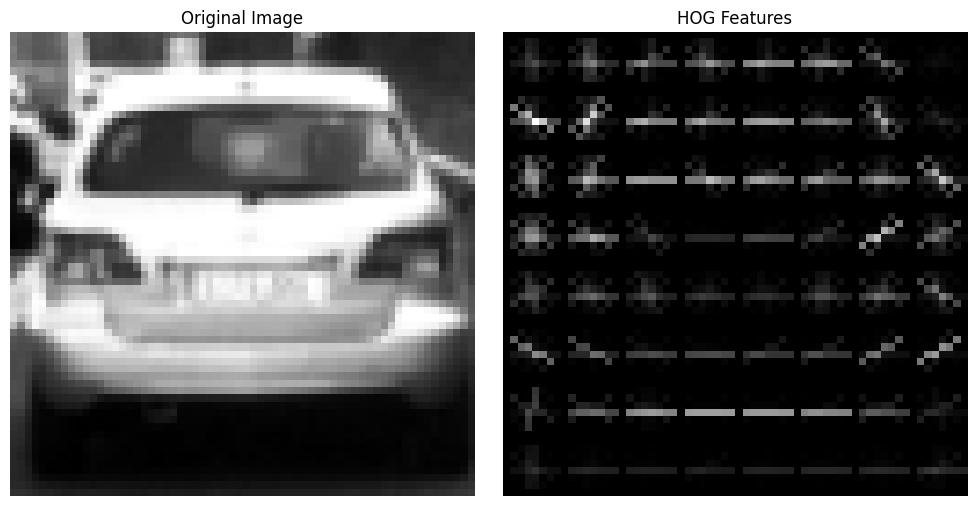

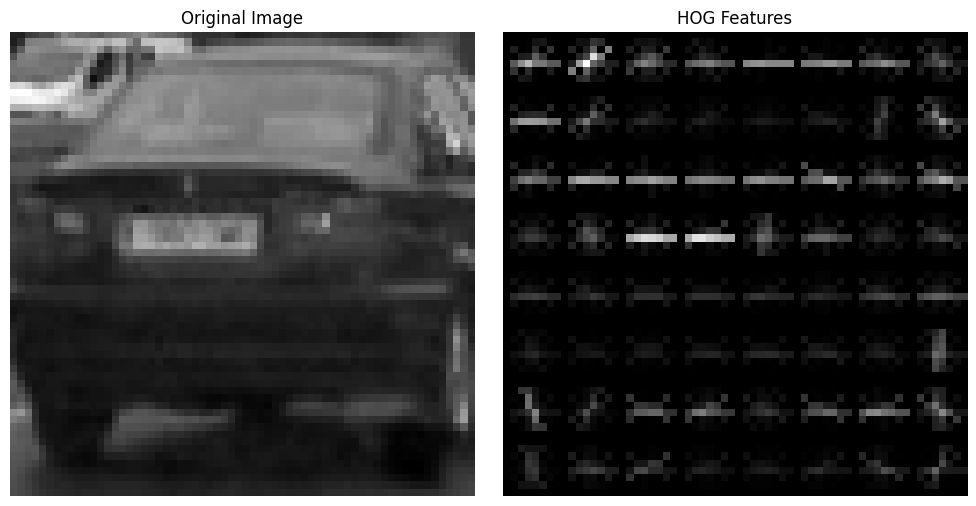

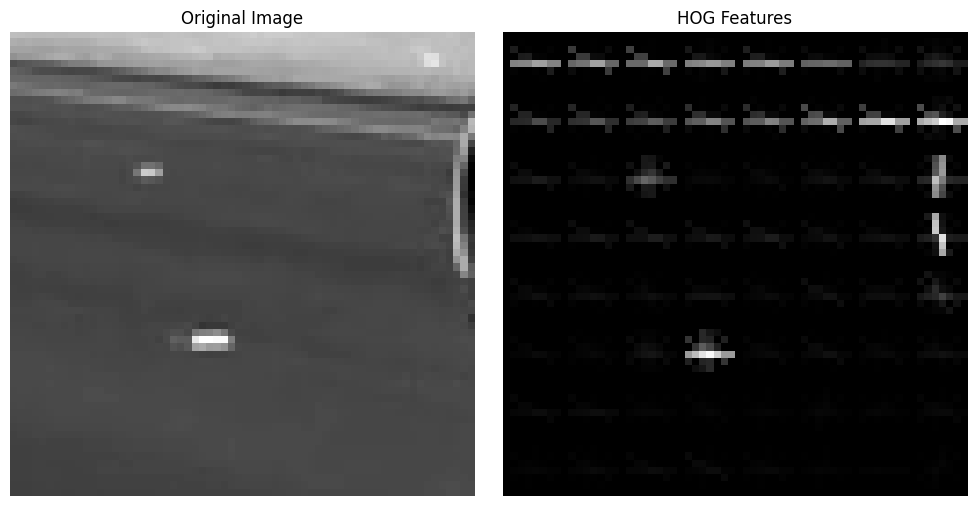

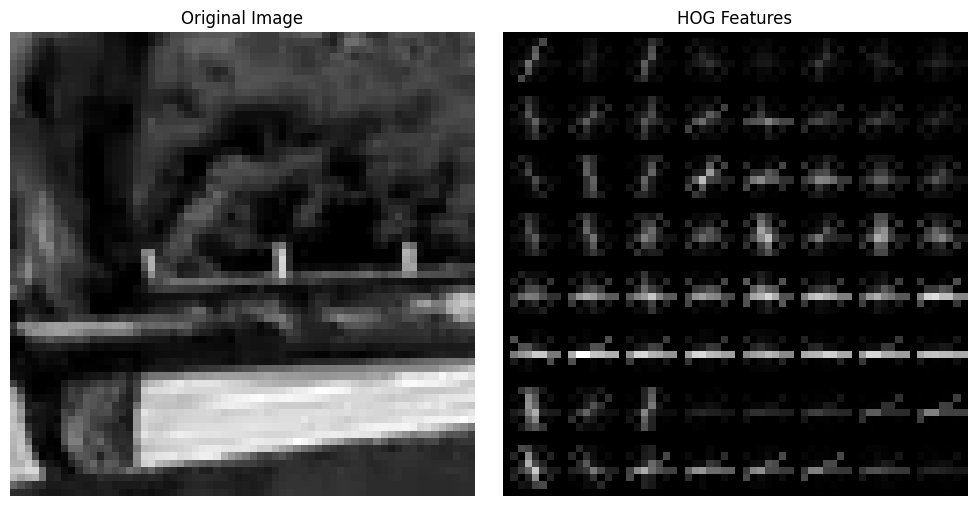

In [7]:
car_samples = random.sample(Car_images, 2)
non_car_samples = random.sample(Non_car_images, 2)

for image_file in car_samples + non_car_samples:
    image = mpimg.imread(image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    features, hog_image = get_hog_features(gray, orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)

    hog_image = (hog_image - np.min(hog_image)) / (np.max(hog_image) - np.min(hog_image))

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].imshow(gray, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(hog_image, cmap='gray')
    ax[1].set_title('HOG Features')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

## *Extract all the feature from the rest of the dataset*

In [8]:
spatial = 32
hist_bins = 32
colorspace = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size= (32, 32)
heat_threshold= 4
hog_channel = "ALL"

car_features = extract_features(Car_images, cspace=colorspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, hist_range=(0, 256))

non_car_features = extract_features(Non_car_images,cspace=colorspace,orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, hist_range=(0, 256))

## *Data splitting and model training*

In [9]:
rand_state = np.random.randint(0, 100)

X = np.vstack((car_features, non_car_features)).astype(np.float64)               
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 8460


## *SVM:*

In [11]:
svc = LinearSVC()

svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')  
precision = precision_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print('Confusion matrix:')
print(conf_matrix)
print('\nAccuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)

c:\Users\windown\PycharmProjects\helloWorld\.venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Confusion matrix:
[[1806   13]
 [  23 1710]]

Accuracy:  0.9898648648648649
Recall:  0.9898648648648649
Precision:  0.9898790264583506


## *Window Siding with 3 different scale*

In [11]:
def find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, ystart_ystop_scale, h_shift=0, visualisation=False):
    bbox_detection_list=[]
    box_vis_list=[]
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
       
    for (ystart, ystop, scale) in ystart_ystop_scale:
        box_vis=[]
        # Crop
        img_tosearch = img[ystart:ystop, :, :]
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (int(imshape[1]/scale), int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
        
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 3
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_histogram(subimg, nbins=hist_bins)

                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

                test_prediction = svc.predict(test_features)
                
                if(visualisation):
                    xbox_left = int(xleft*scale)
                    ytop_draw = int(ytop*scale)
                    win_draw = int(window*scale)
                    box_vis.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
                if test_prediction == 1:
                    xbox_left = int(xleft*scale)
                    ytop_draw = int(ytop*scale)
                    win_draw = int(window*scale)
                    bbox_detection_list.append(((xbox_left+h_shift, ytop_draw+ystart),(xbox_left+win_draw+h_shift,ytop_draw+win_draw+ystart)))
                    cv2.rectangle(draw_img,(xbox_left+h_shift, ytop_draw+ystart),(xbox_left+win_draw+h_shift,ytop_draw+win_draw+ystart),(0,0,255),6) 
        box_vis_list += [box_vis]
    return bbox_detection_list, draw_img, box_vis_list

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1279.5, 719.5, -0.5)

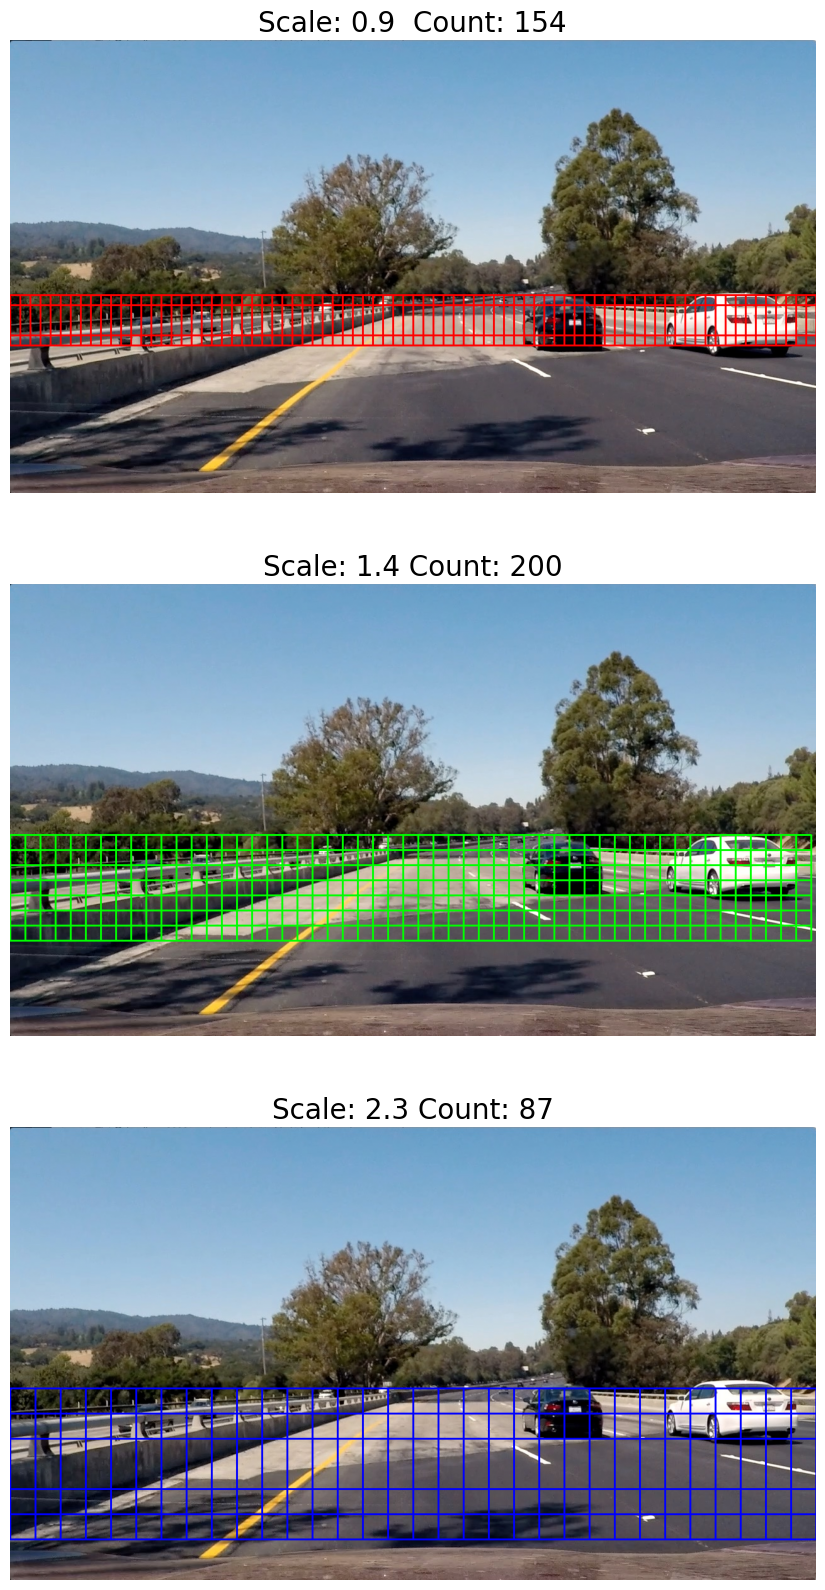

In [12]:
test_image_sliding=test_images[6]
ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (415, 710, 2.5)]
bbox_detection_list, detections, box_vis_list = find_cars(test_image_sliding, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, ystart_ystop_scale, h_shift=500, visualisation=True)

def draw_boxes(img, bboxes, thickness=2):
    imcopy = [np.copy(img),np.copy(img),np.copy(img)]
    color=[(255, 0, 0),(0, 255, 0),(0, 0, 255)]
    for i in range(len(bboxes)):
        for bbox in bboxes[i]:
            cv2.rectangle(img=imcopy[i], pt1=bbox[0], pt2=bbox[1],
                          color=color[i], thickness=thickness)
    return imcopy

windows_img = draw_boxes(test_image_sliding, box_vis_list)

f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(20,20))
ax1.imshow(windows_img[0])
title = "Scale: 0.9 "  + " Count: " + str(len(box_vis_list[0])) 
ax1.set_title(title, fontsize=20)
ax1.axis("off")
ax2.imshow(windows_img[1])
title = "Scale: 1.4"  + " Count: " + str(len(box_vis_list[1])) 
ax2.set_title(title, fontsize=20)
ax2.axis("off")
ax3.imshow(windows_img[2])
title = "Scale: 2.3"  + " Count: " + str(len(box_vis_list[2])) 
ax3.set_title(title, fontsize=20)
ax3.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1279.5, 719.5, -0.5)

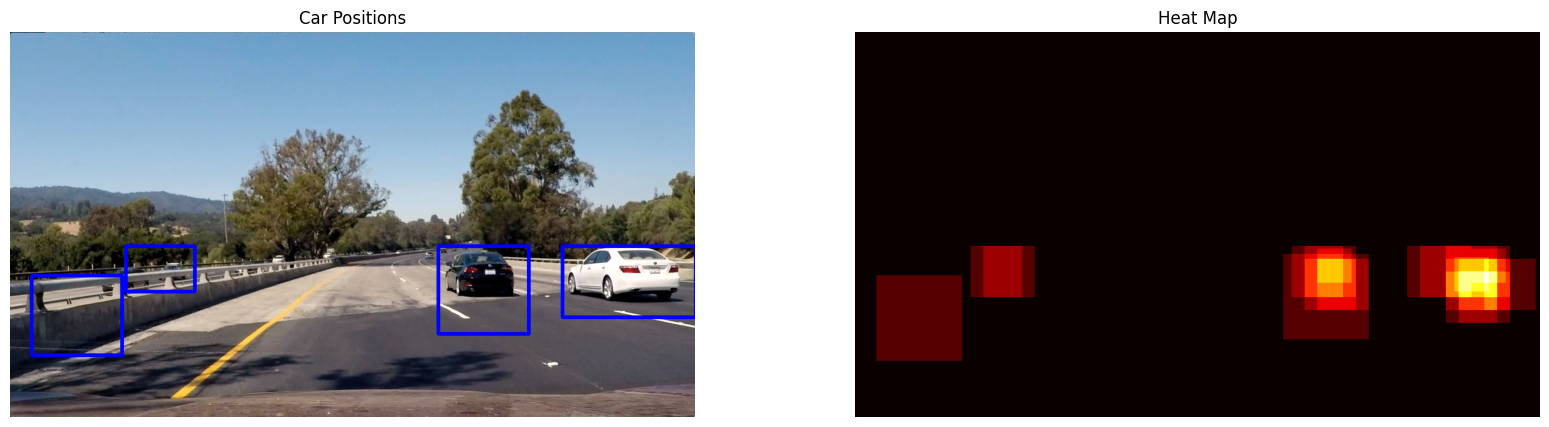

In [13]:
image = test_images[6]
blank = np.zeros_like(image[:,:,0]).astype(float)

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], (bbox[1][0]+10,bbox[1][1]-10), (0,0,255), 6)

    return img


bbox_detection_list, detections, box_vis_list = find_cars(image, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart_ystop_scale)

heatmap = add_heat(blank, bbox_detection_list)

labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize = (20,5))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.axis('off')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.axis('off') 

## *KNN:*
## **KNN Classification**

In [14]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : list(range(1, 21))}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)
best_k = grid_search.best_params_['n_neighbors']
best_k

1

In [19]:
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

In [20]:
print(f'Model score with best k: {best_knn.score(X_test, y_test)}')
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print(f'\nAccuracy: {accuracy_score(y_test, y_pred)}')
print('Recall: ', recall_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))

Model score with best k: 0.9890202702702703
Confusion matrix: 
 [[1817    2]
 [  37 1696]]

Accuracy: 0.9890202702702703
Recall:  0.9786497403346798
Precision:  0.9988221436984688


In [15]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print(f'Model score: {knn.score(X_test, y_test)}')

Model score: 0.9805743243243243


## **Model Evaluation**

In [16]:
y_pred = knn.predict(X_test)

print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print(f'\nAccuracy: {accuracy_score(y_test, y_pred)}')
print('Recall: ', recall_score(y_test, y_pred))
print('Precision: ',precision_score(y_test, y_pred))

Confusion matrix: 
 [[1819    0]
 [  69 1664]]

Accuracy: 0.9805743243243243
Recall:  0.9601846508944027
Precision:  1.0


## **Detecting car with sliding window method**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1279.5, 719.5, -0.5)

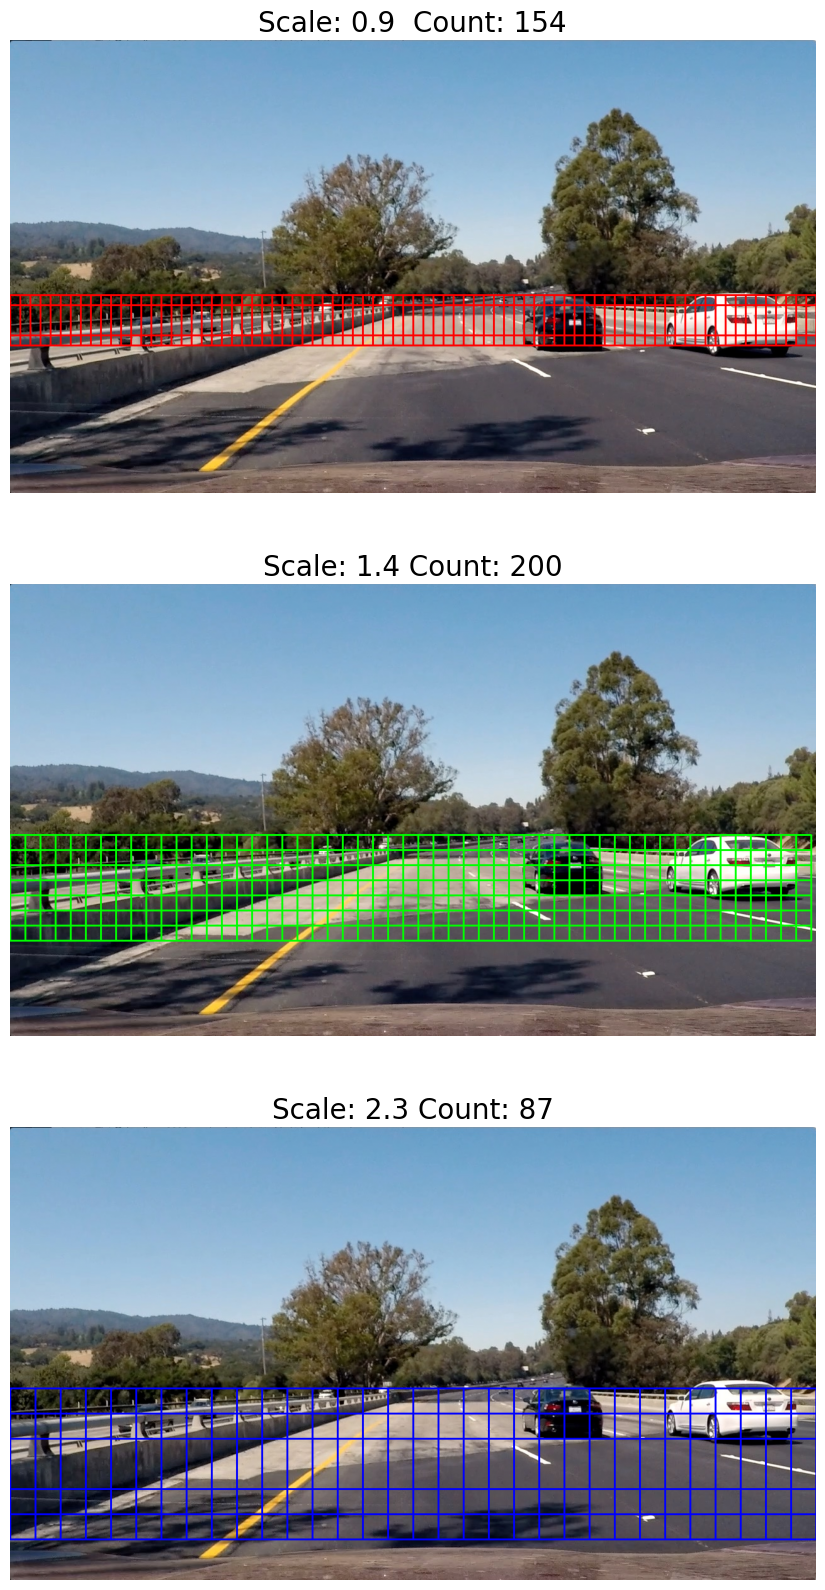

In [17]:
test_image_sliding=test_images[6]
ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (415, 710, 2.5)]
bbox_detection_list, detections, box_vis_list = find_cars(test_image_sliding, knn, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, ystart_ystop_scale, h_shift=500, visualisation=True)

windows_img = draw_boxes(test_image_sliding, box_vis_list)

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20))
ax1.imshow(windows_img[0])
title = "Scale: 0.9 "  + " Count: " + str(len(box_vis_list[0])) 
ax1.set_title(title, fontsize=20)
ax1.axis("off")
ax2.imshow(windows_img[1])
title = "Scale: 1.4"  + " Count: " + str(len(box_vis_list[1])) 
ax2.set_title(title, fontsize=20)
ax2.axis("off")
ax3.imshow(windows_img[2])
title = "Scale: 2.3"  + " Count: " + str(len(box_vis_list[2])) 
ax3.set_title(title, fontsize=20)
ax3.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1279.5, 719.5, -0.5)

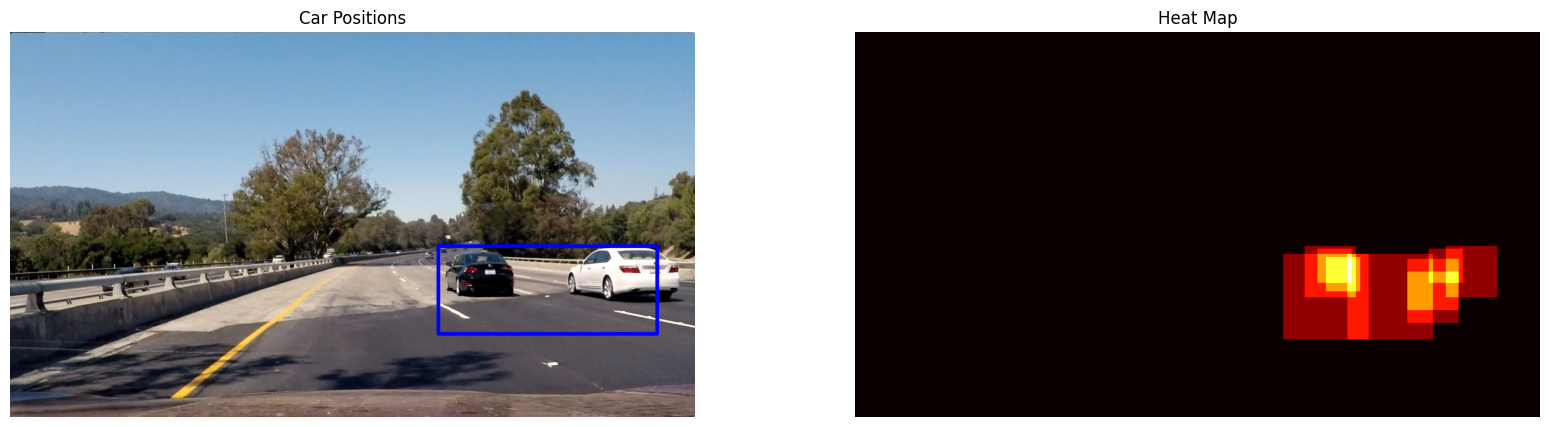

In [18]:
image = test_images[6]
blank = np.zeros_like(image[:,:,0]).astype(float)
bbox_detection_list, detections, box_vis_list = find_cars(image, knn, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart_ystop_scale)

heatmap = add_heat(blank, bbox_detection_list)

labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize = (20,5))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.axis('off')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.axis('off') 